# Dataverwerking michelson interferrometer

## Importeren packages

In [1]:
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.optimize as opt
import scipy.stats as nst

sp.init_printing()

In [2]:
#%matplotlib widget

In [3]:
plt.rcdefaults()
plt.style.use('plot_verslag')

In [4]:
def error(func, variables, S_variables):
    return sp.sqrt(sum([sp.diff(func, var)**2 * S_var**2 for (var, S_var) in zip(variables, S_variables)]))

## Bepalen golflengte laser

Invoeren data

In [5]:
# array met het aantal getelde lijnen en de fout hierop
tellingen = np.array([30, 30, 50, 100, 50])
d_tellingen = np.ones_like(tellingen)/np.sqrt(3)
# array met hoeveel µm de spiegel verschoven was en de fout hierop
afstand = np.array([9.5, 9.5, 16, 31.5, 16])
d_afstand = np.ones_like(afstand)*0.5/np.sqrt(3)

formules voor de golflengte en de fout

In [6]:
x, N, d_x, d_N = sp.symbols("x, N, d_x, d_N")
lam = 2*x/N
d_lam = error(lam, [x, N], [d_x, d_N])

bereken de golflengtes en de fout erop voor de verschillende metingen

In [7]:
golflengtes = sp.lambdify([x, N, d_x, d_N], lam, "numpy")(afstand, tellingen,
                                                         d_afstand, d_tellingen)
d_golflengtes = sp.lambdify([x, N, d_x, d_N], d_lam, "numpy")(afstand, tellingen,
                                                         d_afstand, d_tellingen)
# neem een gewogen gemiddelde van de berekende golflengtes
g = 1/d_golflengtes**2
golflengte = np.dot(golflengtes, g)/np.sum(g)
d_golflengte = 1/np.sqrt(np.sum(g))
display(golflengte*1000, d_golflengte*1000)

## Bepalen brekingsindex

Importeren data

In [8]:
lucht_frame = pd.read_excel("druk-en-tellingen.xlsx", sheet_name="Lucht")
CO2_frame = pd.read_excel("druk-en-tellingen.xlsx", sheet_name="CO2")

Plot van lijnen in functie van drukverschil

In [9]:
def p(N, rico):
    return rico*N/1000
param, covar = opt.curve_fit(p, lucht_frame["tel"], lucht_frame["druk"], (3000), 
                             np.ones_like(lucht_frame["tel"].values))

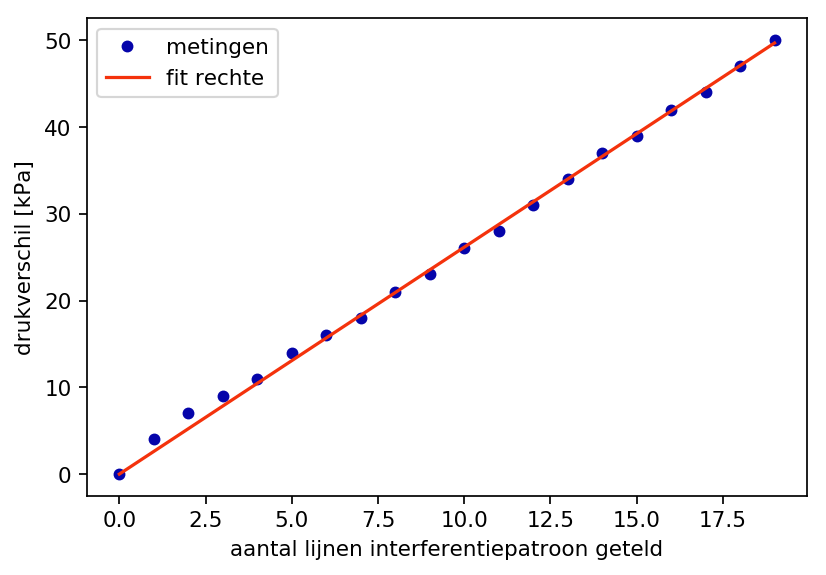

In [10]:
fig, ax = plt.subplots(1,1)

ax.plot(lucht_frame["tel"], lucht_frame["druk"], '.', label="metingen")
N = np.linspace(np.min(lucht_frame["tel"].values),
               np.max(lucht_frame["tel"].values))
ax.plot(N, p(N, param[0]), label="fit rechte")

ax.set_ylabel("drukverschil [kPa]")
ax.set_xlabel("aantal lijnen interferentiepatroon geteld")
plt.legend()

plt.show()
fig.savefig("lucht.pdf")

In [11]:
f, df = sp.symbols('f, df')
S_dNdP = error(1/f, [f], [df])
frac_lucht = 1/param[0]
dfrac_lucht = sp.lambdify([f, df], S_dNdP, "numpy")(param[0], np.sqrt(covar[0]))

brekingsindex lucht

In [12]:
dNdP, L, lam, T, T0, p0, n0 = sp.symbols('dN/dP, L, lambda, T, T_0, p_0, n_0')
SdNdP, SL, Slam, ST, ST0, Sp0 = sp.symbols('S_dN/dP, S_L, S_lambda, S_T, S_T_0, S_p_0')
eq = sp.Eq(dNdP, 2*L/lam * (n0-1)/T * T0/p0)
n0 = sp.solve(eq, n0)[0]
S_n0 = error(n0, [dNdP, L, lam, T, T0, p0], [SdNdP, SL, Slam, ST, ST0, Sp0])
subs = {dNdP:frac_lucht, L:0.0384, lam:golflengte*1e-6, T:293.15, T0:273.15, p0:1.013e5,
       SdNdP:dfrac_lucht, SL:0, Slam:d_golflengte*1e-6, ST:1, ST0:0, Sp0:0}
display(n0.subs(subs), S_n0.subs(subs))

In [13]:
display(lucht_frame["tel"].values[-1]-1,lucht_frame["druk"].values[-1] - 
        lucht_frame["druk"].values[1])

18

46

brekingsindex CO2

In [14]:
def p(N, rico):
    return rico*N/1000
param, covar = opt.curve_fit(p, CO2_frame["tel"], CO2_frame["druk"], (3000), 
                             np.ones_like(CO2_frame["tel"].values))

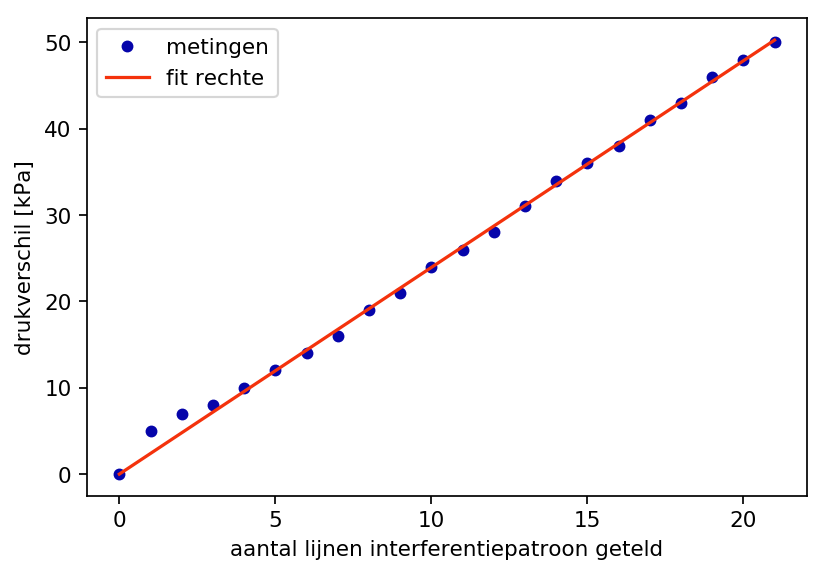

In [15]:
fig, ax = plt.subplots(1,1)

ax.plot(CO2_frame["tel"], CO2_frame["druk"], '.', label="metingen")
N = np.linspace(np.min(CO2_frame["tel"].values),
               np.max(CO2_frame["tel"].values))
ax.plot(N, p(N, param[0]), label="fit rechte")

ax.set_ylabel("drukverschil [kPa]")
ax.set_xlabel("aantal lijnen interferentiepatroon geteld")
plt.legend()

plt.show()
fig.savefig("CO2.pdf")

In [16]:
f, df = sp.symbols('f, df')
S_dNdP = error(1/f, [f], [df])
frac_CO2 = 1/param[0]
dfrac_CO2 = sp.lambdify([f, df], S_dNdP, "numpy")(param[0], np.sqrt(covar[0]))

In [17]:
dNdP, L, lam, T, T0, p0, n0 = sp.symbols('dN/dP, L, lambda, T, T_0, p_0, n_0')
SdNdP, SL, Slam, ST, ST0, Sp0 = sp.symbols('S_dN/dP, S_L, S_lambda, S_T, S_T_0, S_p_0')
eq = sp.Eq(dNdP, 2*L/lam * (n0-1)/T * T0/p0)
n0 = sp.solve(eq, n0)[0]
S_n0 = error(n0, [dNdP, L, lam, T, T0, p0], [SdNdP, SL, Slam, ST, ST0, Sp0])
subs = {dNdP:frac_CO2, L:0.0384, lam:golflengte*1e-6, T:293.15, T0:273.15, p0:1.013e5,
       SdNdP:dfrac_CO2, SL:0, Slam:d_golflengte*1e-6, ST:1, ST0:0, Sp0:0}
display(n0.subs(subs), S_n0.subs(subs))

In [18]:
display(CO2_frame["tel"].values[10]-1,lucht_frame["druk"].values[10] - 
        CO2_frame["druk"].values[1])

9

21

## Tabellen voor bijlage

In [19]:
lucht_frame.index = lucht_frame["tel"]
del lucht_frame["tel"]

In [20]:
print(lucht_frame.to_latex())

\begin{tabular}{lr}
\toprule
{} &  druk \\
tel &       \\
\midrule
0   &     0 \\
1   &     4 \\
2   &     7 \\
3   &     9 \\
4   &    11 \\
5   &    14 \\
6   &    16 \\
7   &    18 \\
8   &    21 \\
9   &    23 \\
10  &    26 \\
11  &    28 \\
12  &    31 \\
13  &    34 \\
14  &    37 \\
15  &    39 \\
16  &    42 \\
17  &    44 \\
18  &    47 \\
19  &    50 \\
\bottomrule
\end{tabular}



In [21]:
CO2_frame.index = CO2_frame["tel"]
del CO2_frame["tel"]

In [22]:
print(CO2_frame.to_latex())

\begin{tabular}{lr}
\toprule
{} &  druk \\
tel &       \\
\midrule
0   &     0 \\
1   &     5 \\
2   &     7 \\
3   &     8 \\
4   &    10 \\
5   &    12 \\
6   &    14 \\
7   &    16 \\
8   &    19 \\
9   &    21 \\
10  &    24 \\
11  &    26 \\
12  &    28 \\
13  &    31 \\
14  &    34 \\
15  &    36 \\
16  &    38 \\
17  &    41 \\
18  &    43 \\
19  &    46 \\
20  &    48 \\
21  &    50 \\
\bottomrule
\end{tabular}

